In [6]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import lmfit
from scipy import signal
from scipy import fftpack
from skimage import util
import operator
from numpy import NaN, Inf, arange, isscalar, asarray, array
import pylab

run = ['001','002','003','004','005','006','007','008','009','010',
       '011','012','013','014','015','016','017','018','019','020', 
       '021','022','023','024','025','026','027','028','029','030',
       '031','032','033','034','035','036']
kx_ind = [0.0125,  0.0150,  0.0175,  0.0200,  0.0225,  0.0250,  0.0275,  0.0300,  0.0325,  0.0350,
          0.0375,  0.0400,  0.0425,  0.0450,  0.0475,  0.0500,  0.1000,  0.2000,  0.3000,  0.4000,
          0.5000,  0.6000,  0.7000,  0.8000,  0.9000,  1.0000,  1.1000,  1.2000,  1.3000,  1.4000,
          1.5000,  1.6000,  1.7000,  1.8000,  1.9000,  2.0000]

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################


#############################################    PEAK DETECTOR     ###########################################

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    FITTING MODEL     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

###########################################    PEAK DETECTOR NUCLEUS     #####################################

def nucleus(E, t, label, diag=False):
    maxdec, mindec = peakdet(np.abs(E), 0.008, x=t)
    maxtab, mintab = peakdet(E, 0.008, x=t)
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(maxdec[:, 1], t=maxdec[:, 0], decay=17, nan_policy='propagate')
    #result = gmodel.fit(maxtab[:, 1], t=maxtab[:, 0], decay=17, nan_policy='propagate')
    print('residual? :' + str(mindec[0, 1]))
    a = maxtab[0, :]  # Initial point (Expected to be ==1)
    e = mintab[0, :]  # (Technically) The lowest point
    i = maxtab[1, :]  # Second Peak
    TP = e[0]         # The time when the peak hits
    OS = np.abs(e[1] / a[1])  # Overshoot ratio
    
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    abs_min = mintab[min_index, :]  # This determines the minimum peak
    
    if (mintab.shape == (1, 2)):  # If there's no o point, then use the absolute minimum
        o = abs_min
        print('Thereis not an o point at {0}. *Taking the absolute minimum*'.format(label))
        DR = np.nan  # And put nothing in the decay ratio
        PE = np.nan  # Or period
    else:
        o = mintab[1, :]  # Gimme my o point if it exists
        
    if maxtab.shape == (2, 2):  # But if there's nothing ahead of the i, just tell me before I start guessing
        print('There is nothing ahead of i')
    else:
        n = 0
        m = 0
        while (i[1] < o[1]) or (i[1] > 0.8):  # If the i is not an appropiate one, find it forward
            i = maxtab[1+n, :]
            n += 1

        while e[1] > i[1]:  # If the height of the lowest point is superior to the second peak, then go ahead
            e = mintab[1+m, :]
            if (mintab.shape != (1, 2)):
                o = mintab[2+m, :]

    DR = np.abs(o[1] / e[1])
    PE = np.abs(o[0] - e[0])
    
    if diag == True:
        print('Diag mode on')
        return maxtab, mintab, OS, DR, PE, TP, a, e, i, o, abs_min
    else:
        return result, OS, DR, PE, TP

#############################################    DIAGNOSTIC TOOL     ###########################################

def diag_lhd(surface, minlim=None, maxlim=None, spectrogram=False, plot=False):
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        kx = kx_ind[0:maxlim]
    if minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    else:
        nummy = run[minlim:maxlim]
        kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind          

    dataset = [('./lhd/s0{0}/GAMDIAGions_0{1}.dat'.format(surface, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True:
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("LHD/s0{0}".format(surface), fontsize=30)
        #plt.xscale('log')
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    integ = []
    rmsvl = []
    decay = []
    osrat = []
    derat = []
    perid = []
    pekti = []
    
    for data, label in datalist:
        E = (data[:,1]*(1/data[0, 1]))
        t = data[:,0]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            if len(nummy) < 11:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        intefield = np.trapz(E, t)
        integ.append(intefield)
        rms = np.sqrt(np.mean(E**2))
        rmsvl.append(rms)
        
        result, OS, DR, PE, TP = nucleus(E, t, label, diag=False)        
        
        decay.append(result.best_values.get('decay'))
        osrat.append(OS)
        derat.append(DR)
        perid.append(PE)
        pekti.append(TP)
    
        if spectrogram == True:
            ########  SPECTROGRAM
            f_s = len(data[:, 0]) / data[-1, 0]
            audio = (data[:,1]*(1/data[0, 1]))
            M = 1024
            slices = util.view_as_windows(audio, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure()
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])
    plt.show()
            
    my_data = np.array([decay, rmsvl, integ, osrat, derat, perid, pekti])
    #data, label = 1, 1
    return datalist, nummy, kx, my_data, data, label

#############################################    DIAGNOSTIC PLOTTER     ###########################################

def diag_plotter(kx, my_data):
#    if np.shape(my_data) != (7, 5):
#        print('Solve the error first!')
#        return
    
    decay = my_data[0, :]
    rmsvl = my_data[1, :]
    integ = my_data[2, :]
    osrat = my_data[3, :]
    derat = my_data[4, :]
    perid = my_data[5, :]
    pekti = my_data[6, :]

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ########  PLOT 1
    ax1.plot(kx, integ)
    ax1.plot(kx, perid)
    ax1.plot(kx, pekti)
    ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    ax1.set_ylim(0, 40)
    ax1.legend(('Integral', 'Period', 'Peak time'))

    ########  PLOT 2
    ax2.plot(kx, osrat)
    ax2.plot(kx, derat)
    ax2.set_ylim(0, 3)
    ax2.legend(('Overshoot ratio', 'Decay ratio'))
    ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ########  RMS
    ax3.title.set_text('RMS')
    ax3.plot(kx, rmsvl)
    ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ########  DECAY TIME
    ax4.title.set_text('Decay time')
    ax4.plot(kx, decay)
    ax4.set_xlabel('$k_{x} \\rho_{ti}$')

    fig.show()
    return

#############################################    TROUBLESHOOTER     #############################################
def troubleshooter(data, label):
    E = (data[:,1]*(1/data[0, 1]))
    t = data[:, 0]
    f_s = len(data[:, 0]) / data[-1, 0]
    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * f_s

    fig = plt.figure(figsize=(13, 13))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.stem(freqs, np.abs(X))
    ax1.set_xlabel('Frequency in Hertz [Hz]')
    ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax1.set_xlim(0, 0.55)  # f_s / 2)
    #ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, DR, PE, TP, a, e, i, o, abs_min = nucleus(E, t, label, diag=True)
    
    n = ['a', 'e', 'i', 'o']
    x = np.array([a, e, i, o])[:,1]
    y = np.array([a, e, i, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for i, txt in enumerate(n):
        ax2.annotate(txt, (y[i], x[i]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Decay Ratio (DR): ' + str(DR))
    print('Period (P): ' + str(PE))
    print('Peak time (t_p): ' + str(TP))
    fig.show()
    
    return 
    

In [ ]:
%matplotlib inline

residual? :0.0016761670466818675
residual? :0.01594463778551142


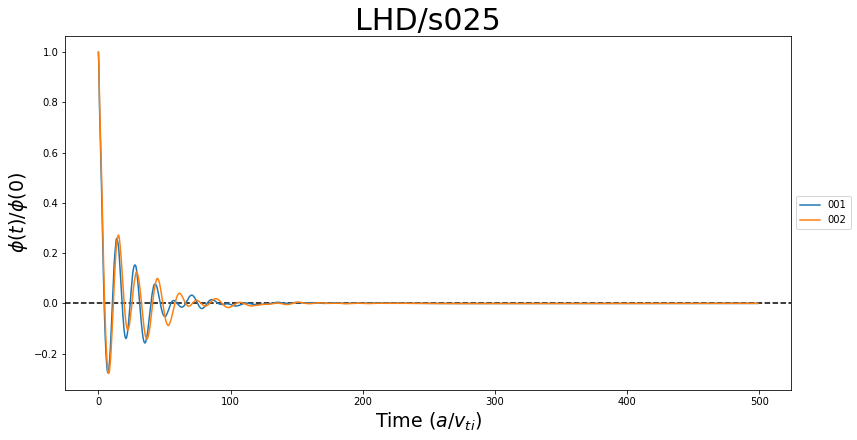

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Stored 'lhd_E' (ndarray)
Stored 'lhd_t' (ndarray)


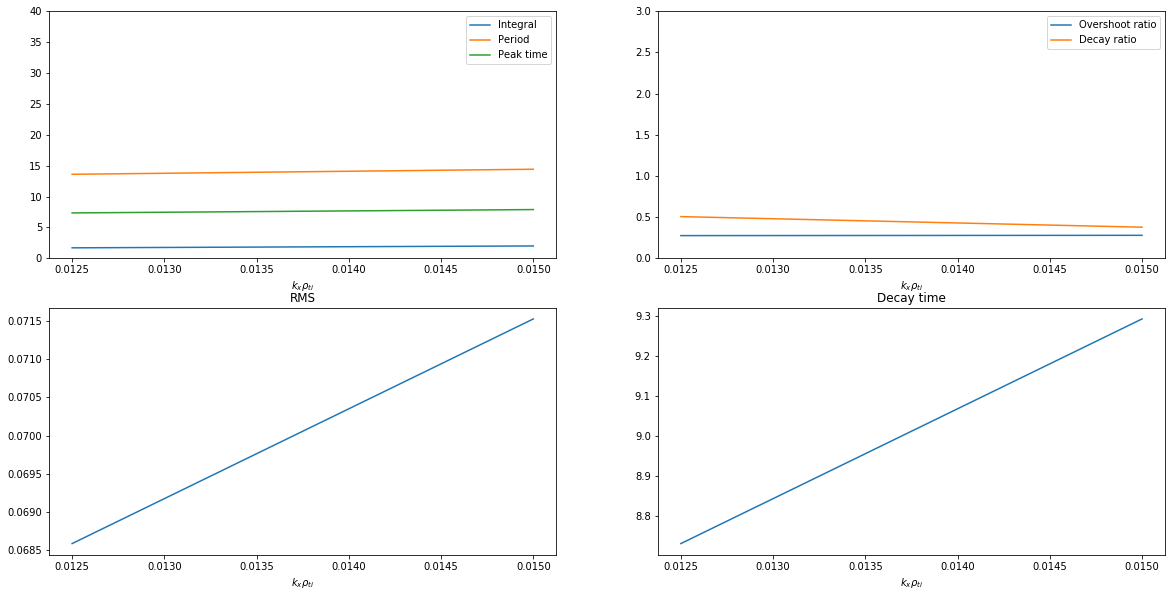

In [7]:
datalist, nummy, kx, my_data_25, data, label = diag_lhd(25, maxlim=2, plot=True)
diag_plotter(kx, my_data_25)
lhd_E = (data[:,1]*(1/data[0, 1]))
lhd_t = data[:,0]
%store lhd_E
%store lhd_t

residual? :0.01741387069353468
residual? :0.011296564828241413
residual? :0.018186909345467277
residual? :0.00783589179458973
residual? :0.014651732586629334
residual? :0.001023351167558378
residual? :0.00456242812140607
residual? :0.004496624831241563
residual? :0.00039388969448472425
residual? :0.006611630581529077
residual? :0.006166908345417272
residual? :0.0052662633131656585
residual? :0.0035382769138456926
residual? :0.010341517075853793
residual? :0.004030201510075504
residual? :0.0014407720386019303
residual? :0.008244612230611532
residual? :0.002628631431571579
residual? :0.0057564878243912205
residual? :0.004929046452322616
residual? :0.0011943597179858993
residual? :0.0015173758687934398
residual? :0.0009665279916795006
residual? :0.0002705262315738944
residual? :0.00012663759825589534


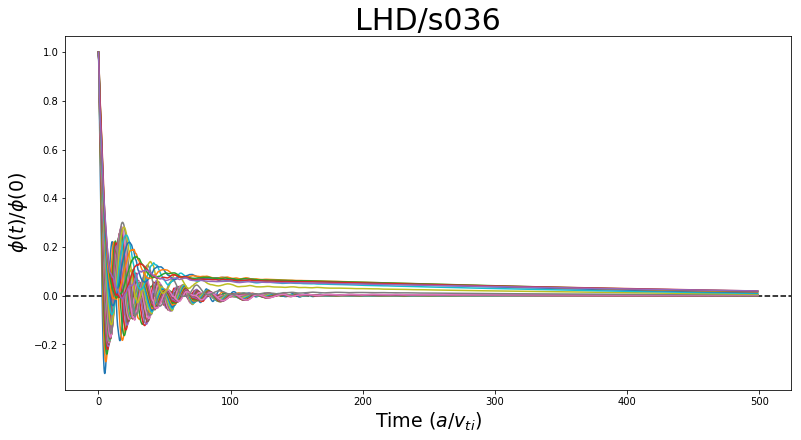

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


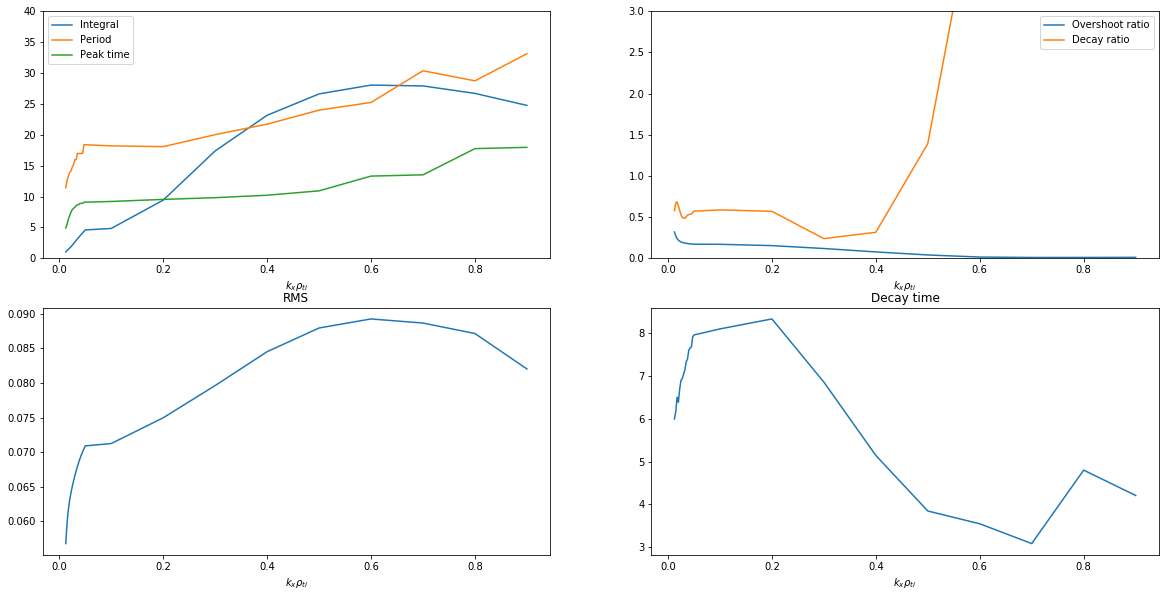

In [3]:
datalist, nummy, kx, my_data_36, data, label = diag_lhd(36, maxlim=25, plot=True)
diag_plotter(kx, my_data_36)

residual? :0.002984708929625074
residual? :0.008820617443221025
residual? :0.004709029632074245
residual? :0.0046472253057714035
residual? :0.005414979048533398
residual? :0.0026616863180422626
residual? :0.004295300671046973
residual? :0.0029139039732781293
residual? :0.0007096996789775284
residual? :0.0022060544238096664
residual? :0.003452741691918434
residual? :0.0028028962027341914
residual? :0.002485473983178823
residual? :0.002717690238316682
residual? :0.0018127268908823618
residual? :0.000612182852799696
residual? :0.00095353674757233
residual? :0.010364725530787156
residual? :0.03766863680457632
residual? :0.060763253427739944
residual? :0.07415719100337023
residual? :0.07538927724940747
residual? :0.07447721340493835
residual? :0.06871481003670256
residual? :0.023162621383496847


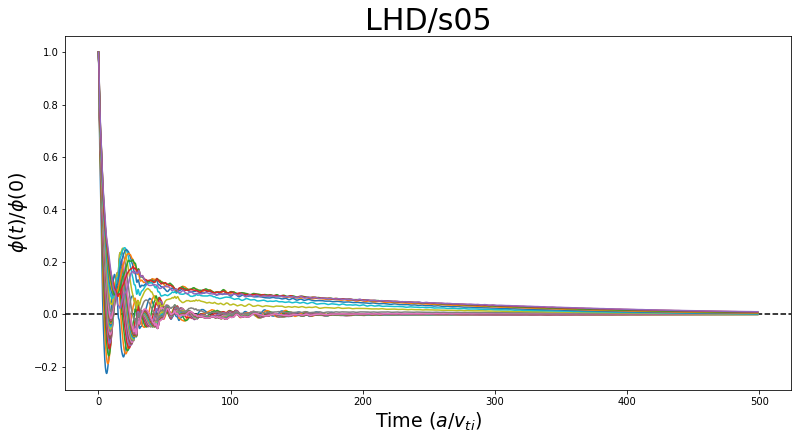

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


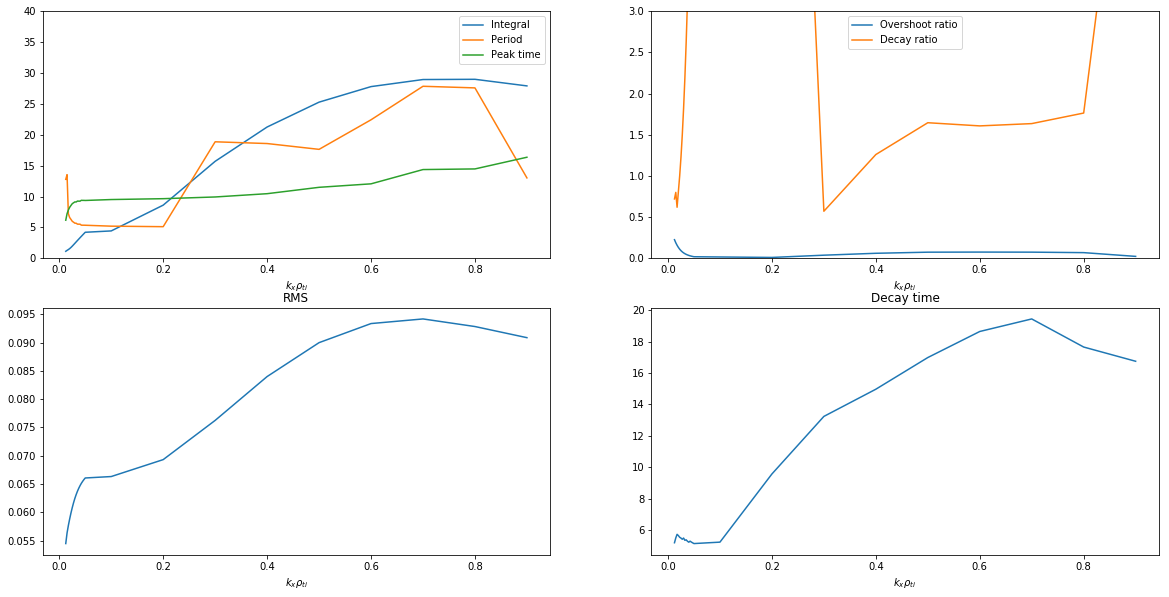

In [4]:
datalist, nummy, kx, my_data_5, data, label = diag_lhd(5, maxlim=25, plot=True)
diag_plotter(kx, my_data_5)

residual? :0.005031702536202895
residual? :0.004191535322825826
residual? :0.005234318745499639
residual? :0.005838767101368109
residual? :0.0036292903432274576
residual? :0.005398631890551243
residual? :0.0019813585086806943
residual? :0.001467017361388911
residual? :0.0037480998479878388
residual? :0.0008651392111368909
residual? :0.001515821265701256
residual? :0.0008331166493319465
residual? :0.00030204416353308265
residual? :0.008642691415313226
residual? :0.019165533242659412
residual? :0.028569285542843423
residual? :0.03701296103688295
residual? :0.1117389391151292
residual? :0.14964197135770863
residual? :0.16579492154293887
residual? :0.17191547239251534
residual? :0.171495434589113
residual? :0.4071166404976448
residual? :0.0663929753677831
residual? :0.07443844384438443


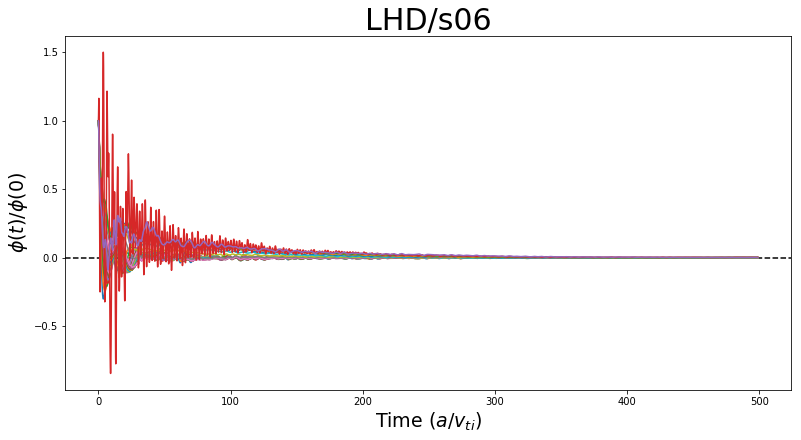

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


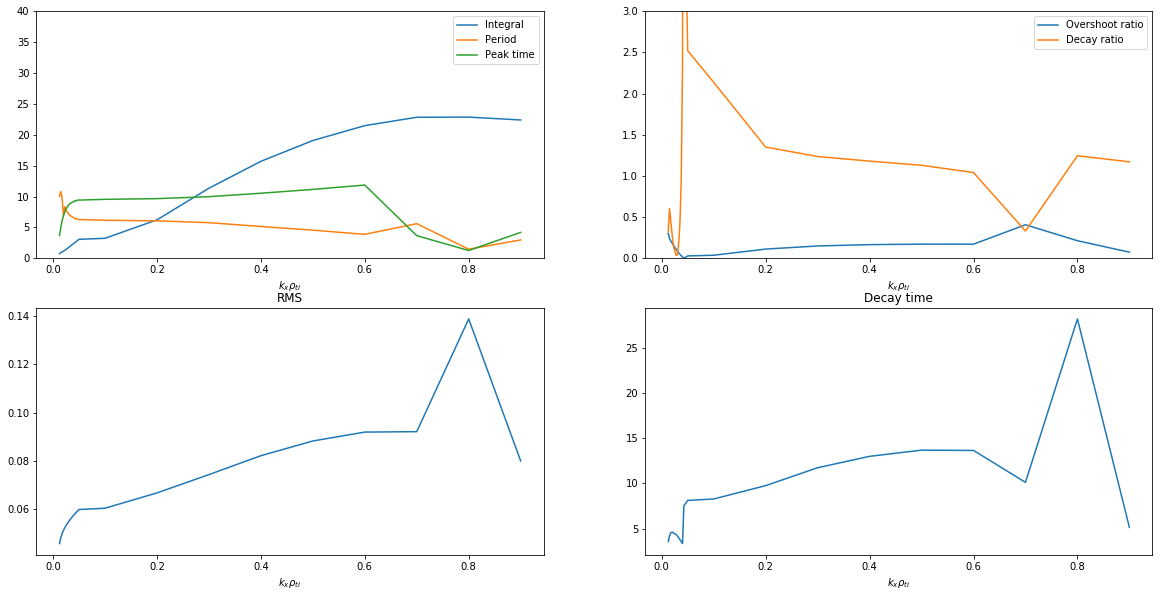

In [5]:
datalist, nummy, kx, my_data_6, data, label = diag_lhd(6, maxlim=25, plot=True)
diag_plotter(kx, my_data_6)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.integrate import odeint

# specify number of steps
ns = 120
# define time points
t = np.linspace(0,ns/10.0,ns+1)

class model(object):
    # default process model
    Kp = 2.0
    taus = 0.5
    thetap = 2.0
    zeta = 0.15

def process(x,t,u,Kp,taus,zeta):
    # Kp = process gain
    # taus = second order time constant
    # zeta = damping factor
    # ts^2 dy2/dt2 + 2 zeta taus dydt + y = Kp u(t-thetap)
    y = x[0]
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*taus*dydt - y + Kp*u)/taus**2
    return [dydt,dy2dt2]

def calc_response(t,m):
    # t = time points
    # m = process model
    Kp = m.Kp
    taus = m.taus
    thetap = m.thetap
    zeta = m.zeta

    print('Kp: ' + str(Kp))
    print('taus: ' + str(taus))
    print('zeta: ' + str(zeta))

    # specify number of steps
    ns = len(t)-1
    delta_t = t[1]-t[0]

    # storage for recording values
    op = np.zeros(ns+1)  # controller output
    pv = np.zeros((ns+1,2))  # process variable

    # step input
    op[10:]=1.0

    # Simulate time delay
    ndelay = int(np.ceil(thetap / delta_t)) 

    # loop through time steps    
    for i in range(0,ns):
        # implement time delay
        iop = max(0,i-ndelay)
        inputs = (op[iop],Kp,taus,zeta)
        y = odeint(process,pv[i],[0,delta_t],args=inputs)
        pv[i+1] = y[-1]
    return (pv,op) 

# underdamped step response
(pv,op) = calc_response(t,model)

# rename parameters
tau = model.taus
zeta = model.zeta
du = 2.0
s = 3.0

# peak time
tp = np.pi * tau / np.sqrt(1.0-zeta**2)
# rise time
tr = tau / (np.sqrt(1.0-zeta**2)) * (np.pi-np.arccos(zeta))
# overshoot ratio
os = np.exp(-np.pi * zeta / (np.sqrt(1.0-zeta**2)))
# decay ratio
dr = os**2
# period
p = 2.0 * np.pi * tau / (np.sqrt(1.0-zeta**2))

print('Summary of response')
print('rise time: ' + str(tr))
print('peak time: ' + str(tp))
print('overshoot: ' + str(os))
print('decay ratio: ' + str(dr))
print('period: ' + str(p))

plt.figure(1)
g = gs.GridSpec(2, 1, height_ratios=[3, 1]) 
ap = {'arrowstyle': '->'}

plt.subplot(g[0])
plt.plot(t,pv[:,0],'b-',linewidth=3,label='Underdamped')
plt.plot([0,max(t)],[2.0,2.0],'r--',label='Steady State')
plt.plot([1,1],[0,0.5],'k-')
plt.plot([3,3],[0,0.5],'k-')
plt.plot([3+tr,3+tr],[0,2],'k-')
plt.plot([3+tp,3+tp],[0,2],'k-')
plt.plot([3,3+tr],[2,2],'g-',linewidth=2)
plt.plot([3,3+tp],[2*(1+os),2*(1+os)],'g-',linewidth=2)
plt.plot([3+tp,3+tp+p],[3,3],'k--',linewidth=2)
plt.plot([3+tp,3+tp],[2,2*(1.0+os)],'r-',linewidth=3)
plt.plot([3+tp+p,3+tp+p],[2,2*(1+os*dr)],'r-',linewidth=3)
plt.legend(loc=4)
plt.ylabel('Process Output')

tloc = (1.05,0.2)
txt = r'$Delay\,(\theta_p=2)$'
plt.annotate(s=txt,xy=tloc)

tloc = (2,2.1)
txt = r'$Rise\,Time\,(t_r)$'
plt.annotate(s=txt,xy=tloc)

tloc = (2,3)
txt = r'$Peak\,Time\,(t_p)$'
plt.annotate(s=txt,xy=tloc)

tloc = (5,3.1)
txt = r'$Period\,(P)$'
plt.annotate(s=txt,xy=tloc)

tloc = (3+tp+0.05,1.0)
txt = r'$A$'
plt.annotate(s=txt,xy=tloc)

tloc = (3+tp+0.05,2.1)
txt = r'$B$'
plt.annotate(s=txt,xy=tloc)

tloc = (3+tp+p+0.05,2.1)
txt = r'$C$'
plt.annotate(s=txt,xy=tloc)

tloc = (6,2.7)
txt = r'$Decay\,Ratio\,(\frac{C}{B})$'
plt.annotate(s=txt,xy=tloc)

tloc = (5.5,1.0)
txt = r'$Overshoot\,Ratio\,(\frac{B}{A})$'
plt.annotate(s=txt,xy=tloc)

plt.subplot(g[1])
plt.plot(t,op,'k:',linewidth=3,label='Step Input')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.ylabel('Process Input')
plt.xlabel('Time')

pt = (1.0,0.5)
tloc = (2.0,0.5)
txt = r'$Step\,Input\,Starts$'
plt.annotate(s=txt,xy=pt,xytext=tloc,arrowprops=ap)

plt.show()

In [ ]:
zf_integral1 = []
zf_fft = []
zf_step = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral1.append(intefield)
plt.figure()
zf_integral1 = np.array(zf_integral1)
plt.plot(kx, zf_integral1)
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)
#plt.xscale('log')
plt.show()
plt.figure()
zf_integral1 = np.array(zf_integral1)
for data, label in datalist:
    L = np.fft.fft((data[:,1]*(1/data[0, 1])))
    plt.plot([x.real for x in L], label='{0}'.format(label))
#plt.legend(nummy, title='$k_{x}$', fontsize=14)
plt.yscale('log')
plt.show()
plt.figure()
zf_integral1 = np.array(zf_integral1)
for data, label in datalist:
    L = np.fft.rfft((data[:,1]*(1/data[0, 1])))
    plt.plot([x.real for x in L], label='{0}'.format(label))
plt.legend(nummy, title='$k_{x}$', fontsize=14)
plt.yscale('log')
plt.show()

In [ ]:
L = np.fft.fft((data[:,1]*(1/data[0, 1])))
X = [x.real for x in L]
Y = [x.imag for x in L]
plt.plot(X, color='b')
plt.plot(Y, color='r')
plt.show()

In [ ]:
#nummy = itemgetter(1, 2, 3, 4, 5)(run)
#kx = itemgetter(1, 2, 3, 4, 5)(kx_ind)
nummy = run[0:20]
kx =     kx_ind[0:20]
dataset = [('./lhd/s036/GAMDIAGions_0{0}.dat'.format(index), index) for index in nummy] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
plt.figure(figsize=(13, 6.5))

zf_decay_36 = []
zf_rms_36 = []
zf_integral_36 = []
zf_os_36 = []
zf_dr_36 = []
zf_pe_36 = []
zf_tp_36 = []

for data, label in datalist:
    E = (data[:,1]*(1/data[0, 1]))
    t = data[:,0]
    maxtab, mintab = peakdet(E, 0.01, x=t)
    plt.plot(t, E, label='{0}'.format(label))  # plot all the oscillations
    y = maxtab[:, 1]
    t = maxtab[:, 0]
    result = gmodel.fit(y, t=t, decay=17, nan_policy='propagate')
    zf_decay_36.append(result.best_values.get('decay'))
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_36.append(intefield)
    rms = np.sqrt(np.mean((data[:,1]*(1/data[0, 1]))**2))
    zf_rms_36.append(rms)
    
    a = maxtab[0, :]
    e = mintab[0, :]
    i = maxtab[1, :]
    o = mintab[1, :]
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))
    real_e = mintab[min_index, :]
    if o[1] > real_e[1]:
        o = real_e
    OS = np.abs(e[1] / a[1])
    zf_os_36.append(OS)
    TP = e[0]
    zf_tp_36.append(TP)
    n = 0
    while (i[1] < o[1]) or (i[1] > 0.8):
        i = maxtab[1+n, :]
        n += 1
    if e[1] > i[1]:
        e = mintab[1, :]
        o = mintab[2, :]
    OS = np.abs(e[1] / a[1])
    
    if mintab.shape == (1, 2):  # This won't work for W7X
        zf_dr_36.append(np.nan)
        zf_pe_36.append(np.nan)
    else:
        DR = np.abs(o[1] / e[1])
        zf_dr_36.append(DR)
        PE = np.abs(o[0] - e[0])
        zf_pe_36.append(PE)
#    if PE < 1:
#        o = mintab[2, :]
#        PE = np.abs(o[0] - e[0])
    
plt.axhline(y=0, color='black', linestyle='dashed')
#plt.legend(kx, title='$k_{x}$', fontsize=14)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("LHD/s036", fontsize=30)
#plt.xscale('log')
plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)

ax1.title.set_text('Integral')
ax2.title.set_text('RMS')
ax3.title.set_text('Spectrogram')
ax4.title.set_text('Decay time')
ax5.title.set_text('Overshoot ratio')
ax6.title.set_text('Decay ratio')
ax7.title.set_text('Period')
ax8.title.set_text('Peak time')
                   
########  INTEGRAL
ax1.plot(kx, zf_integral_36)

########  RMS
ax2.plot(kx, zf_rms_36)

########  SPECTROGRAM
f_s = len(data[:, 0]) / data[-1, 0]
audio = (data[:,1]*(1/data[0, 1]))
M = 1024
slices = util.view_as_windows(audio, window_shape=(M,), step=2)
win = np.hanning(M + 1)[:-1]
slices = slices * win
slices = slices.T
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)
S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax3.imshow(S, origin='lower', cmap='viridis')
ax3.axis('tight')
ax3.set_ylabel('Frequency [Hz]')
ax3.set_xlabel('Time ($a / v_{ti}$)')
#ax3.ylim([0, 0.3])
fig.show()

########  DECAY TIME
ax4.plot(kx, zf_decay_36)
ax4.set_xlabel('$k_{x} \\rho_{ti}$')

########  OVERSHOOT RATIO
ax5.plot(kx, zf_os_36)
ax5.set_xlabel('$k_{x} \\rho_{ti}$')

########  DECAY RATIO
ax6.plot(kx, zf_dr_36)
ax6.set_xlabel('$k_{x} \\rho_{ti}$')

########  PERIOD
ax7.plot(kx, zf_pe_36)
ax7.set_xlabel('$k_{x} \\rho_{ti}$')

########  PEAK TIME
ax8.plot(kx, zf_tp_36)
ax8.set_xlabel('$k_{x} \\rho_{ti}$')

In [ ]:
#nummy = itemgetter(1, 2, 3, 4, 5)(run)
#kx = itemgetter(1, 2, 3, 4, 5)(kx_ind)
nummy = run[0:20]
kx =     kx_ind[0:20]
dataset = [('./lhd/s05/GAMDIAGions_0{0}.dat'.format(index), index) for index in nummy] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
plt.figure(figsize=(13, 6.5))

zf_decay_5 = []
zf_rms_5 = []
zf_integral_5 = []
zf_os_5 = []
zf_dr_5 = []
zf_pe_5 = []
zf_tp_5 = []

for data, label in datalist:
    E = (data[:,1]*(1/data[0, 1]))
    t = data[:,0]
    maxtab, mintab = peakdet(E, 0.01, x=t)
    plt.plot(t, E, label='{0}'.format(label))  # plot all the oscillations
    y = maxtab[:, 1]
    t = maxtab[:, 0]
    result = gmodel.fit(y, t=t, decay=17, nan_policy='propagate')
    zf_decay_5.append(result.best_values.get('decay'))
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_5.append(intefield)
    rms = np.sqrt(np.mean((data[:,1]*(1/data[0, 1]))**2))
    zf_rms_5.append(rms)
    
    a = maxtab[0, :]
    e = mintab[0, :]
    i = maxtab[1, :]
    o = mintab[1, :]
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))
    real_e = mintab[min_index, :]
    if o[1] > real_e[1]:
        o = real_e
    OS = np.abs(e[1] / a[1])
    zf_os_5.append(OS)
    TP = e[0]
    zf_tp_5.append(TP)
    n = 0
    while (i[1] < o[1]) or (i[1] > 0.8):
        i = maxtab[1+n, :]
        n += 1
    if e[1] > i[1]:
        e = mintab[1, :]
        o = mintab[2, :]
    OS = np.abs(e[1] / a[1])
    
    if mintab.shape == (1, 2):  # This won't work for W7X
        zf_dr_5.append(np.nan)
        zf_pe_5.append(np.nan)
    else:
        DR = np.abs(o[1] / e[1])
        zf_dr_5.append(DR)
        PE = np.abs(o[0] - e[0])
        zf_pe_5.append(PE)
#    if PE < 1:
#        o = mintab[2, :]
#        PE = np.abs(o[0] - e[0])
    
plt.axhline(y=0, color='black', linestyle='dashed')
#plt.legend(kx, title='$k_{x}$', fontsize=14)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("LHD/s05", fontsize=30)
#plt.xscale('log')
plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)

ax1.title.set_text('Integral')
ax2.title.set_text('RMS')
ax3.title.set_text('Spectrogram')
ax4.title.set_text('Decay time')
ax5.title.set_text('Overshoot ratio')
ax6.title.set_text('Decay ratio')
ax7.title.set_text('Period')
ax8.title.set_text('Peak time')
                   
########  INTEGRAL
ax1.plot(kx, zf_integral_5)

########  RMS
ax2.plot(kx, zf_rms_5)

########  SPECTROGRAM
f_s = len(data[:, 0]) / data[-1, 0]
audio = (data[:,1]*(1/data[0, 1]))
M = 1024
slices = util.view_as_windows(audio, window_shape=(M,), step=2)
win = np.hanning(M + 1)[:-1]
slices = slices * win
slices = slices.T
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)
S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax3.imshow(S, origin='lower', cmap='viridis')
ax3.axis('tight')
ax3.set_ylabel('Frequency [Hz]')
ax3.set_xlabel('Time ($a / v_{ti}$)')
#ax3.ylim([0, 0.3])
fig.show()

########  DECAY TIME
ax4.plot(kx, zf_decay_5)
ax4.set_xlabel('$k_{x} \\rho_{ti}$')

########  OVERSHOOT RATIO
ax5.plot(kx, zf_os_5)
ax5.set_xlabel('$k_{x} \\rho_{ti}$')

########  DECAY RATIO
ax6.plot(kx, zf_dr_5)
ax6.set_xlabel('$k_{x} \\rho_{ti}$')

########  PERIOD
ax7.plot(kx, zf_pe_5)
ax7.set_xlabel('$k_{x} \\rho_{ti}$')

########  PEAK TIME
ax8.plot(kx, zf_tp_5)
ax8.set_xlabel('$k_{x} \\rho_{ti}$')

In [ ]:
#nummy = itemgetter(1, 2, 3, 4, 5)(run)
#kx = itemgetter(1, 2, 3, 4, 5)(kx_ind)
nummy = run[0:13]
kx =     kx_ind[0:13]
dataset = [('./lhd/s06/GAMDIAGions_0{0}.dat'.format(index), index) for index in nummy] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
plt.figure(figsize=(13, 6.5))

zf_decay_6 = []
zf_rms_6 = []
zf_integral_6 = []
zf_os_6 = []
zf_dr_6 = []
zf_pe_6 = []
zf_tp_6 = []

for data, label in datalist:
    E = (data[:,1]*(1/data[0, 1]))
    t = data[:,0]
    maxtab, mintab = peakdet(E, 0.01, x=t)
    plt.plot(t, E, label='{0}'.format(label))  # plot all the oscillations
    y = maxtab[:, 1]
    t = maxtab[:, 0]
    result = gmodel.fit(y, t=t, decay=17, nan_policy='propagate')
    zf_decay_6.append(result.best_values.get('decay'))
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_6.append(intefield)
    rms = np.sqrt(np.mean((data[:,1]*(1/data[0, 1]))**2))
    zf_rms_6.append(rms)
    
    a = maxtab[0, :]
    e = mintab[0, :]
    i = maxtab[1, :]
    o = mintab[1, :]
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))
    real_e = mintab[min_index, :]
    if o[1] > real_e[1]:
        o = real_e
    OS = np.abs(e[1] / a[1])
    zf_os_6.append(OS)
    TP = e[0]
    zf_tp_6.append(TP)
    n = 0
    while (i[1] < o[1]) or (i[1] > 0.8):
        i = maxtab[1+n, :]
        n += 1
    if e[1] > i[1]:
        e = mintab[1, :]
        o = mintab[2, :]
    OS = np.abs(e[1] / a[1])
    
    if mintab.shape == (1, 2):  # This won't work for W7X
        zf_dr_6.append(np.nan)
        zf_pe_6.append(np.nan)
    else:
        DR = np.abs(o[1] / e[1])
        zf_dr_6.append(DR)
        PE = np.abs(o[0] - e[0])
        zf_pe_6.append(PE)
#    if PE < 1:
#        o = mintab[2, :]
#        PE = np.abs(o[0] - e[0])
    
plt.axhline(y=0, color='black', linestyle='dashed')
#plt.legend(kx, title='$k_{x}$', fontsize=14)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("LHD/s06", fontsize=30)
#plt.xscale('log')
plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)

ax1.title.set_text('Integral')
ax2.title.set_text('RMS')
ax3.title.set_text('Spectrogram')
ax4.title.set_text('Decay time')
ax5.title.set_text('Overshoot ratio')
ax6.title.set_text('Decay ratio')
ax7.title.set_text('Period')
ax8.title.set_text('Peak time')
                   
########  INTEGRAL
ax1.plot(kx, zf_integral_6)

########  RMS
ax2.plot(kx, zf_rms_6)

########  SPECTROGRAM
f_s = len(data[:, 0]) / data[-1, 0]
audio = (data[:,1]*(1/data[0, 1]))
M = 1024
slices = util.view_as_windows(audio, window_shape=(M,), step=2)
win = np.hanning(M + 1)[:-1]
slices = slices * win
slices = slices.T
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)
S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax3.imshow(S, origin='lower', cmap='viridis')
ax3.axis('tight')
ax3.set_ylabel('Frequency [Hz]')
ax3.set_xlabel('Time ($a / v_{ti}$)')
#ax3.ylim([0, 0.3])
fig.show()

########  DECAY TIME
ax4.plot(kx, zf_decay_6)
ax4.set_xlabel('$k_{x} \\rho_{ti}$')

########  OVERSHOOT RATIO
ax5.plot(kx, zf_os_6)
ax5.set_xlabel('$k_{x} \\rho_{ti}$')

########  DECAY RATIO
ax6.plot(kx, zf_dr_6)
ax6.set_xlabel('$k_{x} \\rho_{ti}$')

########  PERIOD
ax7.plot(kx, zf_pe_6)
ax7.set_xlabel('$k_{x} \\rho_{ti}$')

########  PEAK TIME
ax8.plot(kx, zf_tp_6)
ax8.set_xlabel('$k_{x} \\rho_{ti}$')

In [ ]:
#############################################    DIAGNOSTIC     #############################################


x = (data[:,1]*(1/data[0, 1]))
t = data[:, 0]
f_s = len(data[:, 0]) / data[-1, 0]
X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s

fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.stem(freqs, np.abs(X))
ax1.set_xlabel('Frequency in Hertz [Hz]')
ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax1.set_xlim(0, 0.55)  # f_s / 2)
#ax2.set_ylim(-2, 2)
ax2.set_xlim(0, 500)
ax2.plot(t, x, label='{0}'.format(label))
ax2.axhline(y=0, color='black', linestyle='dashed')
maxtab, mintab = peakdet(x, 0.01, x=t)
n = 0
a = maxtab[0, :]
e = mintab[0, :]
i = maxtab[1, :]
o = mintab[1, :]
min_index, min_value = min(enumerate(mintab[0:1000, 1]), key=operator.itemgetter(1))
real_e = mintab[min_index, :]

while (i[1] < o[1]) or (i[1] > 0.8):
    i = maxtab[1+n, :]
    n += 1
if e[1] > i[1]:
    e = mintab[1, :]
    o = mintab[2, :]
OS = np.abs(e[1] / a[1])
DR = np.abs(o[1] / e[1])
Pe = np.abs(o[0] - e[0])
#if Pe < 3:
#    o = mintab[2, :]
#    Pe = np.abs(o[0] - e[0])
t_p = e[0]
n = ['a', 'e', 'i', 'o']
x = np.array([a, e, i, o])[:,1]
y = np.array([a, e, i, o])[:,0]
ax2.scatter(y,x, color='blue')
for i, txt in enumerate(n):
    ax2.annotate(txt, (y[i], x[i]))
ax2.scatter(real_e[0], real_e[1], color='green')
ax2.set_xlim(-10, 100)
print('Overshoot ratio (OS): ' + str(OS))
print('Decay Ratio (DR): ' + str(DR))
print('Period (P): ' + str(Pe))
print('Peak time (t_p): ' + str(t_p))
fig.show()

#############################################    DIAGNOSTIC     #############################################

In [ ]:
plt.figure(figsize=(13, 6.5))
plt.plot(kx, zf_integral_25)
plt.plot(kx, zf_integral_36)
plt.plot(kx, zf_integral_5)
plt.plot(kx, zf_integral_6)
#plt.yscale('log')
sumz = np.array([sum(x) for x in zip(zf_integral_25, zf_integral_36, zf_integral_5, zf_integral_6)])
avg = sumz/4
plt.plot(kx, avg, linewidth=3)
plt.title('Integral')
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)
plt.legend(('s = 25', 's = 36', 's = 05', 's = 06', 'avg'))
print(np.shape(avg))
plt.show()

In [ ]:
plt.figure(figsize=(13, 6.5))
plt.plot(kx, zf_rms_25)
plt.plot(kx, zf_rms_36)
plt.plot(kx, zf_rms_5)
plt.plot(kx, zf_rms_6)
#plt.yscale('log')
sumz = np.array([sum(x) for x in zip(zf_rms_25, zf_rms_36, zf_rms_5, zf_rms_6)])
avg = sumz/4
plt.plot(kx, avg, linewidth=3)
plt.title('RMS')
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)
plt.legend(('s = 25', 's = 36', 's = 05', 's = 06', 'avg'))
print(np.shape(avg))
plt.show()

In [ ]:
plt.figure(figsize=(13, 6.5))
plt.plot(kx, zf_os_25)
plt.plot(kx, zf_os_36)
plt.plot(kx, zf_os_5)
plt.plot(kx, zf_os_6)
#plt.yscale('log')
sumz = np.array([sum(x) for x in zip(zf_os_25, zf_os_36, zf_os_5, zf_os_6)])
avg = sumz/4
plt.plot(kx, avg, linewidth=3)
plt.title('Overshoot ratio')
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)
plt.legend(('s = 25', 's = 36', 's = 05', 's = 06', 'avg'))
print(np.shape(avg))
plt.show()

In [ ]:
plt.figure(figsize=(13, 6.5))
plt.plot(kx, zf_dr_25)
plt.plot(kx, zf_dr_36)
plt.plot(kx, zf_dr_5)
plt.plot(kx, zf_dr_6)
#plt.yscale('log')
sumz = np.array([sum(x) for x in zip(zf_dr_25, zf_dr_36, zf_dr_5, zf_dr_6)])
avg = sumz/4
plt.plot(kx, avg, linewidth=3)
plt.title('Decay Ratio')
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)
plt.legend(('s = 25', 's = 36', 's = 05', 's = 06', 'avg'))
print(np.shape(avg))
plt.show()

In [ ]:
plt.figure(figsize=(13, 6.5))
plt.plot(kx, zf_decay_25)
plt.plot(kx, zf_decay_36)
plt.plot(kx, zf_decay_5)
plt.plot(kx, zf_decay_6)
#plt.yscale('log')
sumz = np.array([sum(x) for x in zip(zf_decay_25, zf_decay_36, zf_decay_5, zf_decay_6)])
avg = sumz/4
plt.plot(kx, avg, linewidth=3)
plt.title('decay')
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)
plt.legend(('s = 25', 's = 36', 's = 05', 's = 06', 'avg'))
print(np.shape(avg))
plt.show()

In [ ]:
nummy4L = ['001','002','003','004','005','006','007','008','009','010',
           '011','012','013','014','015','016','017','018','019','020']
kxc4L = [0.000,  0.105,  0.211,  0.316,  0.421,  0.526,  0.632,  0.737,  0.842,  0.947,
         1.053,  1.158,  1.263,  1.368,  1.474,  1.579,  1.684,  1.789,  1.895,  2.000]
del nummy4L[3]
del kxc4L[3]
del nummy4L[4]
del kxc4L[4]
del nummy4L[6]
del kxc4L[6]
del nummy4L[14]
del kxc4L[14]
nummy = nummy4L
dataset = [('./ZFs/LHD-P-L_004/GAMDIAGions_0{0}.dat'.format(index), index) for index in nummy] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
plt.figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(nummy, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_os4L = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_os4L.append(intefield)
plt.figure()
plt.plot(kxc4L, zf_os4L)
#plt.yscale('log')
plt.show()

In [ ]:
plt.figure()
plt.plot(kxcL, zf_osL)
plt.plot(kxc2L, zf_os2L)
plt.plot(kxc3L, zf_os3L)
plt.plot(kxc4L, zf_os4L)
#plt.yscale('log')
sumz = np.array([sum(x) for x in zip(zf_osL, zf_os2L, zf_os3L, zf_os4L)])
avg2 = sumz/4
plt.plot(kxc4L, avg2, linewidth=3)
plt.show()

In [ ]:
plt.figure()
plt.xscale('log')
plt.ylim([0.0, 300])
plt.plot(kxc2, avg, linewidth=3)
plt.plot(kxc4L, avg2, linewidth=3)
plt.show()